In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr

# Using Orthogonal Distance Regression to fit a template

What I mean by a "template" is that you have some model for how the data should look (the template), and you also have a model for how the data might be different from the template. This is often the case for calibrating data to a known signal.

For example, if we make a measurement of a calibration signal, $s(x)$, but expect our data will have a gain factor, we may model our data as:  
$d(x) = g \times s(x)$

Or maybe it's a bit more complicated with a linear additive noise. That would look something like:  
$d(x) = g \times s(x) + n'x + n_0$

Let's see if ODR can do the job of fitting for $g$, $n'$, and $n_0$.

## Set up data
First we set up a template and a mock data set.

In [2]:
xdata = np.arange(-7, 7, .2)
template = 3.2 * np.exp(-(xdata - 0.8)**2 / (2 * 1.5**2))

# Of course we wouldn't know these "true" values in a real experiment
g_true = 0.3
np_true = 0.12
n0_true = 3.1

yerr = 0.1
ydata = g_true * template + np_true * xdata + n0_true + yerr * np.random.randn(len(xdata))

<IPython.core.display.Javascript object>


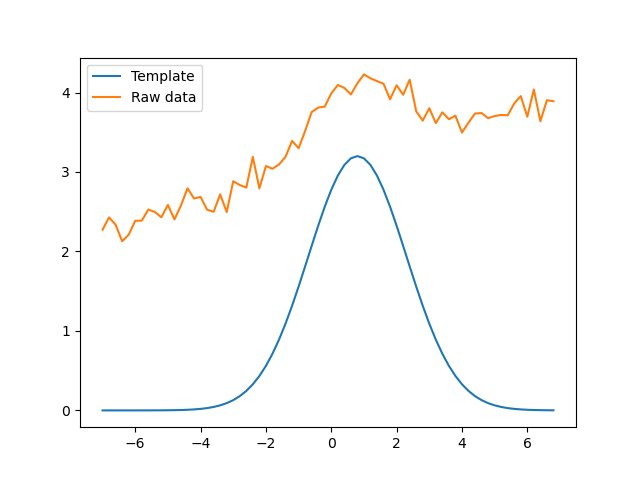

In [3]:
plt.figure()
plt.plot(xdata, template, label='Template')
plt.plot(xdata, ydata, label='Raw data')
plt.legend();

Yikes, that data doesn't look much like the template. We have our work cut out for us.

## Fit with ODR

Next let's stuff our data and model into the ODR format.

In [4]:
# Create a model function
def cal_model(B, x):
    '''
    Model for how our parameters contaminate our data.
    B is a vector of the fit parameters plus the template
        B[0] is the gain
        B[1] is the linear noise term
        B[2] is the constant noise term
    x is an array of the x values    
    
    Returns an array of template modified by the parameters
    '''
    return B[0] * template + B[1] * x + B[2]

Note that I'm neglecting the uncertainties in this little trial.

In [5]:
model = odr.Model(cal_model)
mydata = odr.RealData(xdata, ydata)
myodr = odr.ODR(mydata, model, beta0=[1, 0, 0], ifixx=np.ones(len(xdata)))
myoutput = myodr.run()

myoutput.pprint()

Beta: [0.30001209 0.11908784 3.08878601]
Beta Std Error: [0.01232096 0.00334946 0.01706394]
Beta Covariance: [[ 0.01238091 -0.00058618 -0.01070358]
 [-0.00058618  0.00091498  0.00059557]
 [-0.01070358  0.00059557  0.02374775]]
Residual Variance: 0.01226129028451056
Inverse Condition #: 0.062521149138621
Reason(s) for Halting:
  Sum of squares convergence


<IPython.core.display.Javascript object>


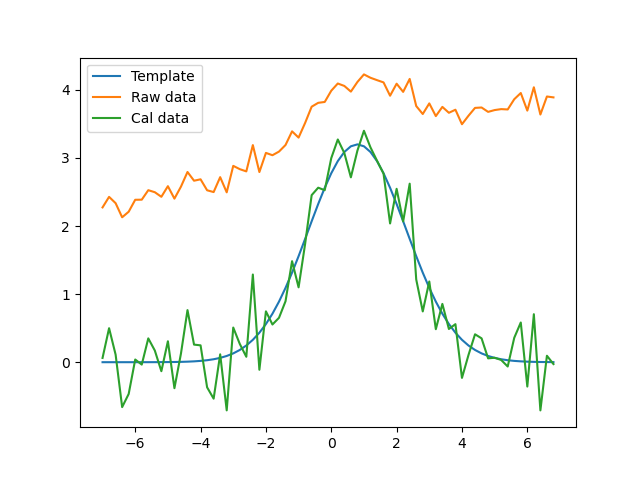

In [6]:
plt.figure()
plt.plot(xdata, template, label='Template')
plt.plot(xdata, ydata, label='Raw data')
caldata = (ydata - myoutput.beta[2] - myoutput.beta[1] * xdata) / myoutput.beta[0]
plt.plot(xdata, caldata, label='Cal data' )
plt.legend();

I'd say that worked pretty well!